## Initialization

### Imports and options

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
%config Application.log_level="WARN"

In [6]:
%matplotlib inline

In [7]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { margin-left: 25%; width:70% !important; }</style>"))

In [8]:
import os
import sys
from glob import glob
import io
import tarfile

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
import ase
from asap3.analysis.rdf import RadialDistributionFunction

# file formats, input - output
import ase.io
from ase.io import read
from ase.io import NetCDFTrajectory

import scipy.constants as C

In [11]:
import postprocessing

In [12]:
from fireworks.utilities.filepad import FilePad 

In [13]:
fp = FilePad(
    host='localhost',
    port=27018,
    database='fireworks-jhoermann',
    username='fireworks',
    password='fireworks')

In [14]:
content, doc = fp.get_file(identifier='surfactant_on_AU_111_df_json')

In [15]:
sim_df = pd.read_json(content, orient='index')

### Poster plotting

In [236]:
# matplotlib settings

# expecially for presentation, larger font settings for plotting are recommendable
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure titlex

plt.rcParams["figure.figsize"] = (16,10) # the standard figure size

plt.rcParams["lines.linewidth"] = 3
plt.rcParams["lines.markersize"] = 14
plt.rcParams["lines.markeredgewidth"]=1 

### Constants and factors

#### Forces

$ [F_{LMP}] = \frac{ \mathrm{kcal}}{ \mathrm{mol} \cdot \mathrm{\mathring{A}}} $

$ [F_{PLT}] = \mathrm{nN}$

$ \mathrm{kcal} = 4.184 \mathrm{kJ} = 4.184 \cdot 10^{3} \mathrm{J}$

$ J = N \cdot m$

$ N = J m^{-1} = \frac{ \mathrm{kcal}}{ 4.184 \cdot 10^3 \mathrm{m} }
    = \frac{ \mathrm{kcal}}{ 4.184 \cdot 10^{13} \mathrm{\mathring{A}} }$
    
$ [F_{PLT}] = \mathrm{nN} 
    = \frac{ 10^9 \cdot N_A^{-1}}{ 4.184 \cdot 10^{13} } 
        \frac{\mathrm{kcal}}{\mathrm{mol} \cdot \mathrm{\mathring{A}}}
    = \frac{ 10^{-4} \cdot N_A^{-1}}{ 4.184 } [F_{LMP}]
    = 0.239 \cdot 10^{-4} N_A^{-1} [F_{LMP}] $
    
    
$ \frac{\mathrm{ kcal }}{ {\mathrm{mol} \mathrm{\mathring{A}}}} = 1.66053892103219 \cdot 10^{-11} \frac{\mathrm{J}}{\mathrm{m}}$

In [171]:
C.calorie # kCal -> kJ

4.184

In [172]:
kCal_to_J = C.calorie * 1e3 # kCal -> J

In [173]:
C.angstrom

1e-10

In [174]:
kCal_per_Ang_to_J_per_m = C.calorie * 1e3 / C.angstrom # kCal / Ang -> J / m

In [175]:
kCal_per_Ang_to_nN =C.calorie * 1e3 / C.angstrom *1e9 # kCal / Ang -> n J / m = n N

In [176]:
kCal_per_Ang_to_nN

4.184e+22

In [177]:
1/(C.calorie * 1e3 / C.angstrom *1e9) # kCal / Ang -> n J / m = n N

2.3900573613766728e-23

In [178]:
4.184e13 / C.Avogadro*1e9

0.06947695345147255

In [179]:
(C.calorie * 1e3 / C.angstrom *1e9)/ C.Avogadro

0.06947695345147255

In [180]:
force_conversion_factor = C.calorie * 1e3 / C.angstrom *1e9 / C.Avogadro# kCal / (mol * Ang ) -> n N

In [181]:
force_conversion_factor

0.06947695345147255

In [182]:
1/force_conversion_factor

14.393262086520076

#### Energy conversion

In [183]:
C.eV # in J (SI units)

1.6021766208e-19

In [184]:
eV_to_kCal_per_mol = (C.eV*C.Avogadro)/(C.kilo*C.calorie)

In [185]:
eV_to_kCal_per_mol

23.060548012069496

In [186]:
eV_to_kCal_per_mol

23.060548012069496

In [187]:
gamma_metal_to_gamma_real = eV_to_kCal_per_mol * C.pico / C.femto

In [188]:
gamma_metal_to_gamma_real * 0.02

461.21096024138984

In [189]:
(C.kilo*C.calorie)/C.k

3.0304599174886308e+26

In [190]:
eV_to_kcal_per_mol = C.eV

#### Velocity conversion

In [241]:
velocity_conversion_factor = 1.0e5 # from Ang per fs to m per s 
# (1 Ang / 1 fs = 10^15 Ang / s = 10^15 m / 10^10 s)

### Global labels

In [192]:
force_label         = r'$F \ [ \mathrm{nN} ]$'
distance_label      = r'$d \ [ \mathrm{\AA} ]$'

In [346]:
averaging_time = 2.0

### Functions

In [23]:
def dfFromFpFiles(files):
    dat = []

    for (cont,doc) in files:
        contStream = io.StringIO(cont.decode())
        df = pd.read_csv(contStream,index_col=0, delim_whitespace=True)
        df.index.name = 'time'
        df["distance"] = \
            doc["metadata"]["sb_in_dist"] + df.index * doc["metadata"]["constant_indenter_velocity"]
        dat.append(df)
    
    return dat

In [24]:
def plottableFromDf(
    title_pattern = '''R = {indenter_initial_radius:} {indenter_substrate:} AFM
        tip model approaching {sf_nmolecules:} {surfactant:} on 
        {substrate:} ({sb_crystal_plane:}) substrate.''',
    legend_pattern = '''{sf_preassembly:}, v = {constant_indenter_velocity:g} 
        $\mathrm{{m}}\ \mathrm{{s}}^{{-1}}$, {thermostat:} thermostat.'''):

    plotData = []
    for (cont,doc) in files:
        # create a title from document metadata
        title_raw = title_pattern.format(
            indenter_initial_radius = doc["metadata"]["indenter"]["initial_radius"],
            indenter_substrate = doc["metadata"]["indenter"]["substrate"],
            sf_nmolecules = doc["metadata"]["sf_nmolecules"],
            surfactant = doc["metadata"]["surfactant"],
            sf_preassembly = doc["metadata"]["sf_preassembly"],
            substrate = doc["metadata"]["substrate"],
            sb_crystal_plane = doc["metadata"]["sb_crystal_plane"])
        title = ' '.join(line.strip() for line in title_raw.splitlines())

        # create a plot legend from document metadata
        legend_raw = legend_pattern.format(
                sf_preassembly = doc["metadata"]["sf_preassembly"],
                constant_indenter_velocity = velocity_conversion_factor*doc["metadata"]["constant_indenter_velocity"],
                thermostat = "Langevin" if doc["metadata"]["use_dpd_tstat"] == 0 else "DPD")

        legend = ' '.join(line.strip() for line in legend_raw.splitlines())

        contStream = io.StringIO(cont.decode())
        df = pd.read_csv(contStream,index_col=0, delim_whitespace=True)
        df.index.name = 'time'
        df["distance"] = \
            doc["metadata"]["sb_in_dist"] + df.index * doc["metadata"]["constant_indenter_velocity"]
        plotData.append({'title': title, 'legend': legend, 'data': df})
        
    return plotData

In [25]:
# Creates four polar axes, and accesses them through the returned array
#fig, axes = plt.subplots(2, 2, subplot_kw=dict(polar=True))
def plotThermo(thermo, axes=None, legend=None, title=None):
    global line_list, label_list
    if axes is None:
        fig, axes = plt.subplots(5, 3, figsize=(20,20)) # constrained_layout=True)
        line_list = []
        label_list = []
    else:
        fig = axes[0,0].get_figure()
        
    l = axes[0, 0].plot(thermo["Step"], thermo["TotEng"])[0]
    axes[0, 1].plot(thermo["Step"], thermo["PotEng"])
    axes[0, 2].plot(thermo["Step"], thermo["KinEng"])

    axes[1, 0].plot(thermo["Step"], thermo["Temp"])
    axes[1, 1].plot(thermo["Step"], thermo["Press"])
    axes[1, 2].plot(thermo["Step"], thermo["Enthalpy"])

    axes[2, 0].plot(thermo["Step"], thermo["E_bond"])
    axes[2, 1].plot(thermo["Step"], thermo["E_angle"])
    axes[2, 2].plot(thermo["Step"], thermo["E_dihed"])

    axes[3, 0].plot(thermo["Step"], thermo["E_pair"])
    axes[3, 1].plot(thermo["Step"], thermo["E_vdwl"])
    axes[3, 2].plot(thermo["Step"], thermo["E_coul"])
    
    axes[4, 0].plot(thermo["Step"], thermo["E_long"])
    axes[4, 1].plot(thermo["Step"], thermo["Volume"])

    axes[0,0].set_title("Total Energy")
    axes[0,1].set_title("Potential Energy")
    axes[0,2].set_title("Kinetic Energy")

    axes[1,0].set_title("Temperature")
    axes[1,1].set_title("Pressure")
    axes[1,2].set_title("Enthalpy")

    axes[2, 0].set_title("E_bond")
    axes[2, 1].set_title("E_angle")
    axes[2, 2].set_title("E_dihed")

    axes[3, 0].set_title("E_pair")
    axes[3, 1].set_title("E_vdwl")
    axes[3, 2].set_title("E_coul")
    
    axes[4, 0].set_title("E_long")
    axes[4, 1].set_title("Volume")
    #axes[1, 1].scatter(x, y)

    axes[0,0].set_ylabel("$E$ [ $ \mathrm{kcal} \ \mathrm{mol}^{-1}$]")
    axes[0,1].set_ylabel("$V$ [ $ \mathrm{kcal} \ \mathrm{mol}^{-1}$]")
    axes[0,2].set_ylabel("$K$ [ $ \mathrm{kcal} \ \mathrm{mol}^{-1}$]")

    axes[1,0].set_ylabel("$T$ [ K ]")
    axes[1,1].set_ylabel("$P$ [ atm ]")
    axes[1,2].set_ylabel("$E$ [ $ \mathrm{kcal} \ \mathrm{mol}^{-1}$]")

    axes[2,0].set_ylabel("$E$ [ $ \mathrm{kcal} \ \mathrm{mol}^{-1}$]")
    axes[2,1].set_ylabel("$E$ [ $ \mathrm{kcal} \ \mathrm{mol}^{-1}$]")
    axes[2,2].set_ylabel("$E$ [ $ \mathrm{kcal} \ \mathrm{mol}^{-1}$]")

    axes[3,0].set_ylabel("$E$ [ $ \mathrm{kcal} \ \mathrm{mol}^{-1}$]")
    axes[3,1].set_ylabel("$E$ [ $ \mathrm{kcal} \ \mathrm{mol}^{-1}$]")
    axes[3,2].set_ylabel("$E$ [ $ \mathrm{kcal} \ \mathrm{mol}^{-1}$]")
    
    axes[4,0].set_ylabel("$E$ [ $ \mathrm{kcal} \ \mathrm{mol}^{-1}$]")
    axes[4,1].set_ylabel("$V$ [ $ \mathrm{\AA^3} $ ]")
    #axes[4,1].set_visible(False)
    axes[4,2].set_visible(False)
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    if legend is not None:
        #axes[0,0].legend()
        line_list.append(l)
        label_list.append(legend)
        fig.legend(line_list,label_list,loc="lower right", framealpha=1)
        
    if title is not None:
        fig.suptitle(title)

    #plt.plot( )
    
    return fig, axes

line_list = []
label_list = []

## NVT equilibration

In [152]:
query = {
    'identifier': { '$regex': '.*thermo\.out$'},
    'metadata.surfactant':     'SDS',
    'metadata.sf_nmolecules':  646,
    'metadata.step':           'equilibration_nvt',
    'metadata.sb_multiples':   [51,30,21],
    'metadata.sf_preassembly': {
        '$in': [
            'monolayer',
            'bilayer',
            'hemicylinders'] } }

In [153]:
files = fp.get_file_by_query(query)

In [154]:
len(files)

3

In [155]:
for c,d in files:
    print(d["identifier"])

AFM/AU/111/25Ang/100ns/AU/111/51x30x21/SDS/646/bilayer/equilibration_nvt/thermo.out
AFM/AU/111/25Ang/100ns/AU/111/51x30x21/SDS/646/hemicylinders/equilibration_nvt/thermo.out
AFM/AU/111/25Ang/100ns/AU/111/51x30x21/SDS/646/monolayer/equilibration_nvt/thermo.out


In [156]:
title_pattern = '''R = {indenter_initial_radius:} {indenter_substrate:} AFM
    tip model approaching {sf_nmolecules:} {surfactant:} on 
    {substrate:} ({sb_crystal_plane:}) substrate.'''

In [157]:
legend_pattern = '''{sf_preassembly:}, NVT equilibration.'''

In [158]:
thermoData = []
for (cont,doc) in files:
    # create a title from document metadata
    title_raw = title_pattern.format(
        indenter_initial_radius = doc["metadata"]["indenter"]["initial_radius"],
        indenter_substrate = doc["metadata"]["indenter"]["substrate"],
        sf_nmolecules = doc["metadata"]["sf_nmolecules"],
        surfactant = doc["metadata"]["surfactant"],
        sf_preassembly = doc["metadata"]["sf_preassembly"],
        substrate = doc["metadata"]["substrate"],
        sb_crystal_plane = doc["metadata"]["sb_crystal_plane"])
    title = ' '.join(line.strip() for line in title_raw.splitlines())
    
    # create a plot legend from document metadata
    legend = legend_pattern.format(
            sf_preassembly = doc["metadata"]["sf_preassembly"])
    #legend = ' '.join(line.strip() for line in legend_raw.splitlines())
    
    contStream = io.StringIO(cont.decode())
    df = pd.read_csv(contStream,delim_whitespace=True)
    #df.index.name = 'time'
    #df["distance"] = \
    #    doc["metadata"]["sb_in_dist"] + df.index * doc["metadata"]["constant_indenter_velocity"]
    thermoData.append({'title': title, 'legend': legend, 'data': df})

In [163]:
thermoData[2]["data"].columns

Index(['Step', 'TotEng', 'KinEng', 'PotEng', 'Temp', 'Press', 'Enthalpy',
       'E_bond', 'E_angle', 'E_dihed', 'E_impro', 'E_pair', 'E_vdwl', 'E_coul',
       'E_long', 'E_tail', 'Volume', 'Pxx', 'Pyy', 'Pzz', 'Pxy', 'Pxz', 'Pyz'],
      dtype='object')

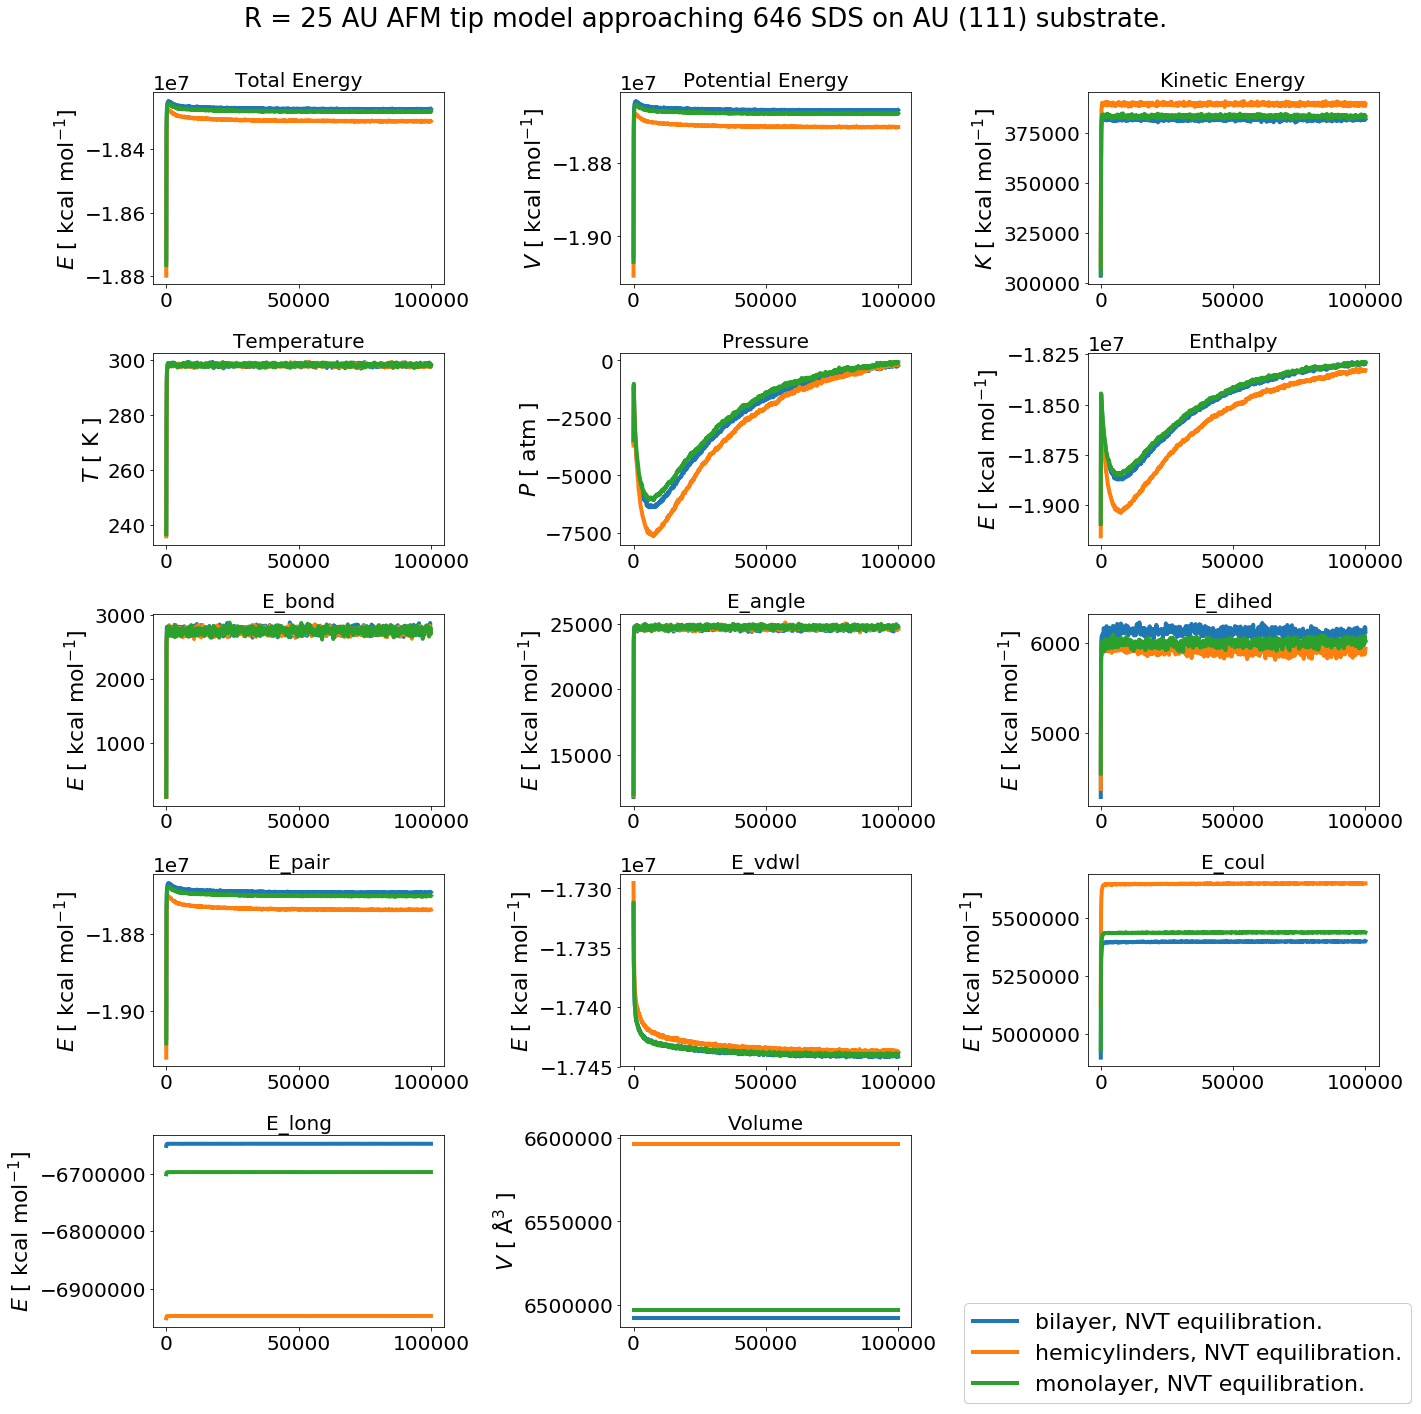

In [159]:
for i, d in enumerate(thermoData):
    if i == 0:
        fig, ax = plotThermo(d["data"], 
                     legend =d["legend"],
                     title  =d["title"])
    else:
        fig, ax = plotThermo(d["data"], axes=ax,
                        legend=d["legend"])

## NPT equilibration:

In [164]:
query = {
    'identifier': { '$regex': '.*thermo\.out$'},
    'metadata.surfactant':     'SDS',
    'metadata.sf_nmolecules':  646,
    'metadata.step':           'equilibration_npt',
    'metadata.sb_multiples':   [51,30,21],
    'metadata.sf_preassembly': {
            '$in': [
                'monolayer',
                'bilayer',
                'hemicylinders'] },
    'metadata.indenter.initial_radius': 25}

In [165]:
files = fp.get_file_by_query(query)

In [167]:
len(files)

3

In [168]:
for c,d in files:
    print(d["identifier"])

AFM/AU/111/25Ang/100ns/AU/111/51x30x21/SDS/646/bilayer/equilibration_npt/thermo.out
AFM/AU/111/25Ang/100ns/AU/111/51x30x21/SDS/646/hemicylinders/equilibration_npt/thermo.out
AFM/AU/111/25Ang/100ns/AU/111/51x30x21/SDS/646/monolayer/equilibration_npt/thermo.out


In [169]:
title_pattern = '''R = {indenter_initial_radius:} {indenter_substrate:} AFM
    tip model approaching {sf_nmolecules:} {surfactant:} on 
    {substrate:} ({sb_crystal_plane:}) substrate.'''

In [170]:
legend_pattern = '''{sf_preassembly:}, NPT equilibration.'''

In [171]:
thermoData = []
for (cont,doc) in files:
    # create a title from document metadata
    title_raw = title_pattern.format(
        indenter_initial_radius = doc["metadata"]["indenter"]["initial_radius"],
        indenter_substrate = doc["metadata"]["indenter"]["substrate"],
        sf_nmolecules = doc["metadata"]["sf_nmolecules"],
        surfactant = doc["metadata"]["surfactant"],
        sf_preassembly = doc["metadata"]["sf_preassembly"],
        substrate = doc["metadata"]["substrate"],
        sb_crystal_plane = doc["metadata"]["sb_crystal_plane"])
    title = ' '.join(line.strip() for line in title_raw.splitlines())
    
    # create a plot legend from document metadata
    legend = legend_pattern.format(
            sf_preassembly = doc["metadata"]["sf_preassembly"])
    #legend = ' '.join(line.strip() for line in legend_raw.splitlines())
    
    contStream = io.StringIO(cont.decode())
    df = pd.read_csv(contStream,delim_whitespace=True)
    #df.index.name = 'time'
    #df["distance"] = \
    #    doc["metadata"]["sb_in_dist"] + df.index * doc["metadata"]["constant_indenter_velocity"]
    thermoData.append({'title': title, 'legend': legend, 'data': df})

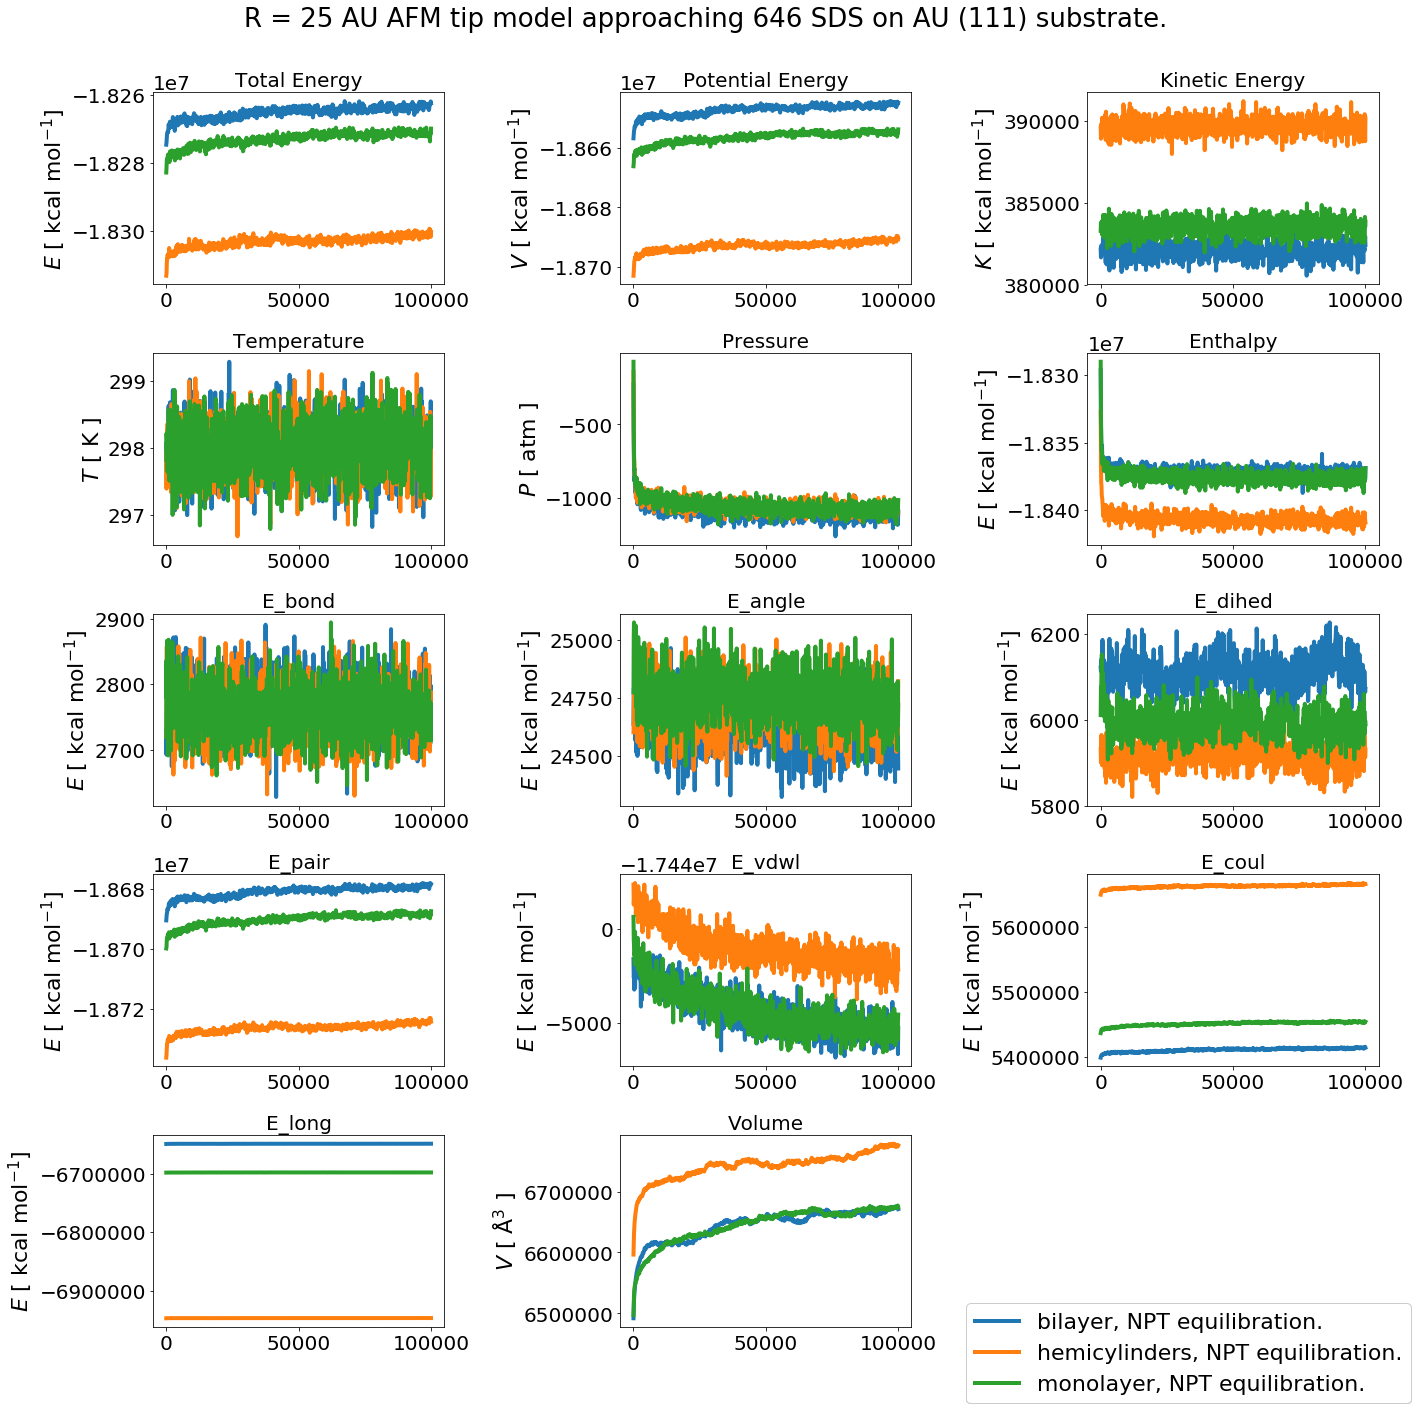

In [172]:
for i, d in enumerate(thermoData):
    if i == 0:
        fig, ax = plotThermo(d["data"], 
                     legend =d["legend"],
                     title  =d["title"])
    else:
        fig, ax = plotThermo(d["data"], axes=ax,
                        legend=d["legend"])

## DPD equilibration

In [173]:
query = {
    'identifier': { '$regex': '.*thermo\.out$'},
    'metadata.surfactant':     'SDS',
    'metadata.sf_nmolecules':  646,
    'metadata.step':           'equilibration_dpd',
    'metadata.sb_multiples':   [51,30,21],
    'metadata.indenter.initial_radius': 25}

In [174]:
files = fp.get_file_by_query(query)

In [176]:
len(files)

3

In [177]:
for c,d in files:
    print(d["identifier"])

AFM/AU/111/25Ang/100ns/AU/111/51x30x21/SDS/646/bilayer/equilibration_dpd/thermo.out
AFM/AU/111/25Ang/100ns/AU/111/51x30x21/SDS/646/hemicylinders/equilibration_dpd/thermo.out
AFM/AU/111/25Ang/100ns/AU/111/51x30x21/SDS/646/monolayer/equilibration_dpd/thermo.out


In [178]:
title_pattern = '''R = {indenter_initial_radius:} {indenter_substrate:} AFM
    tip model approaching {sf_nmolecules:} {surfactant:} on 
    {substrate:} ({sb_crystal_plane:}) substrate.'''

In [179]:
legend_pattern = '''{sf_preassembly:}, NPT equilibration.'''

In [180]:
thermoData = []
for (cont,doc) in files:
    # create a title from document metadata
    title_raw = title_pattern.format(
        indenter_initial_radius = doc["metadata"]["indenter"]["initial_radius"],
        indenter_substrate = doc["metadata"]["indenter"]["substrate"],
        sf_nmolecules = doc["metadata"]["sf_nmolecules"],
        surfactant = doc["metadata"]["surfactant"],
        sf_preassembly = doc["metadata"]["sf_preassembly"],
        substrate = doc["metadata"]["substrate"],
        sb_crystal_plane = doc["metadata"]["sb_crystal_plane"])
    title = ' '.join(line.strip() for line in title_raw.splitlines())
    
    # create a plot legend from document metadata
    legend = legend_pattern.format(
            sf_preassembly = doc["metadata"]["sf_preassembly"])
    #legend = ' '.join(line.strip() for line in legend_raw.splitlines())
    
    contStream = io.StringIO(cont.decode())
    df = pd.read_csv(contStream,delim_whitespace=True)
    #df.index.name = 'time'
    #df["distance"] = \
    #    doc["metadata"]["sb_in_dist"] + df.index * doc["metadata"]["constant_indenter_velocity"]
    thermoData.append({'title': title, 'legend': legend, 'data': df})

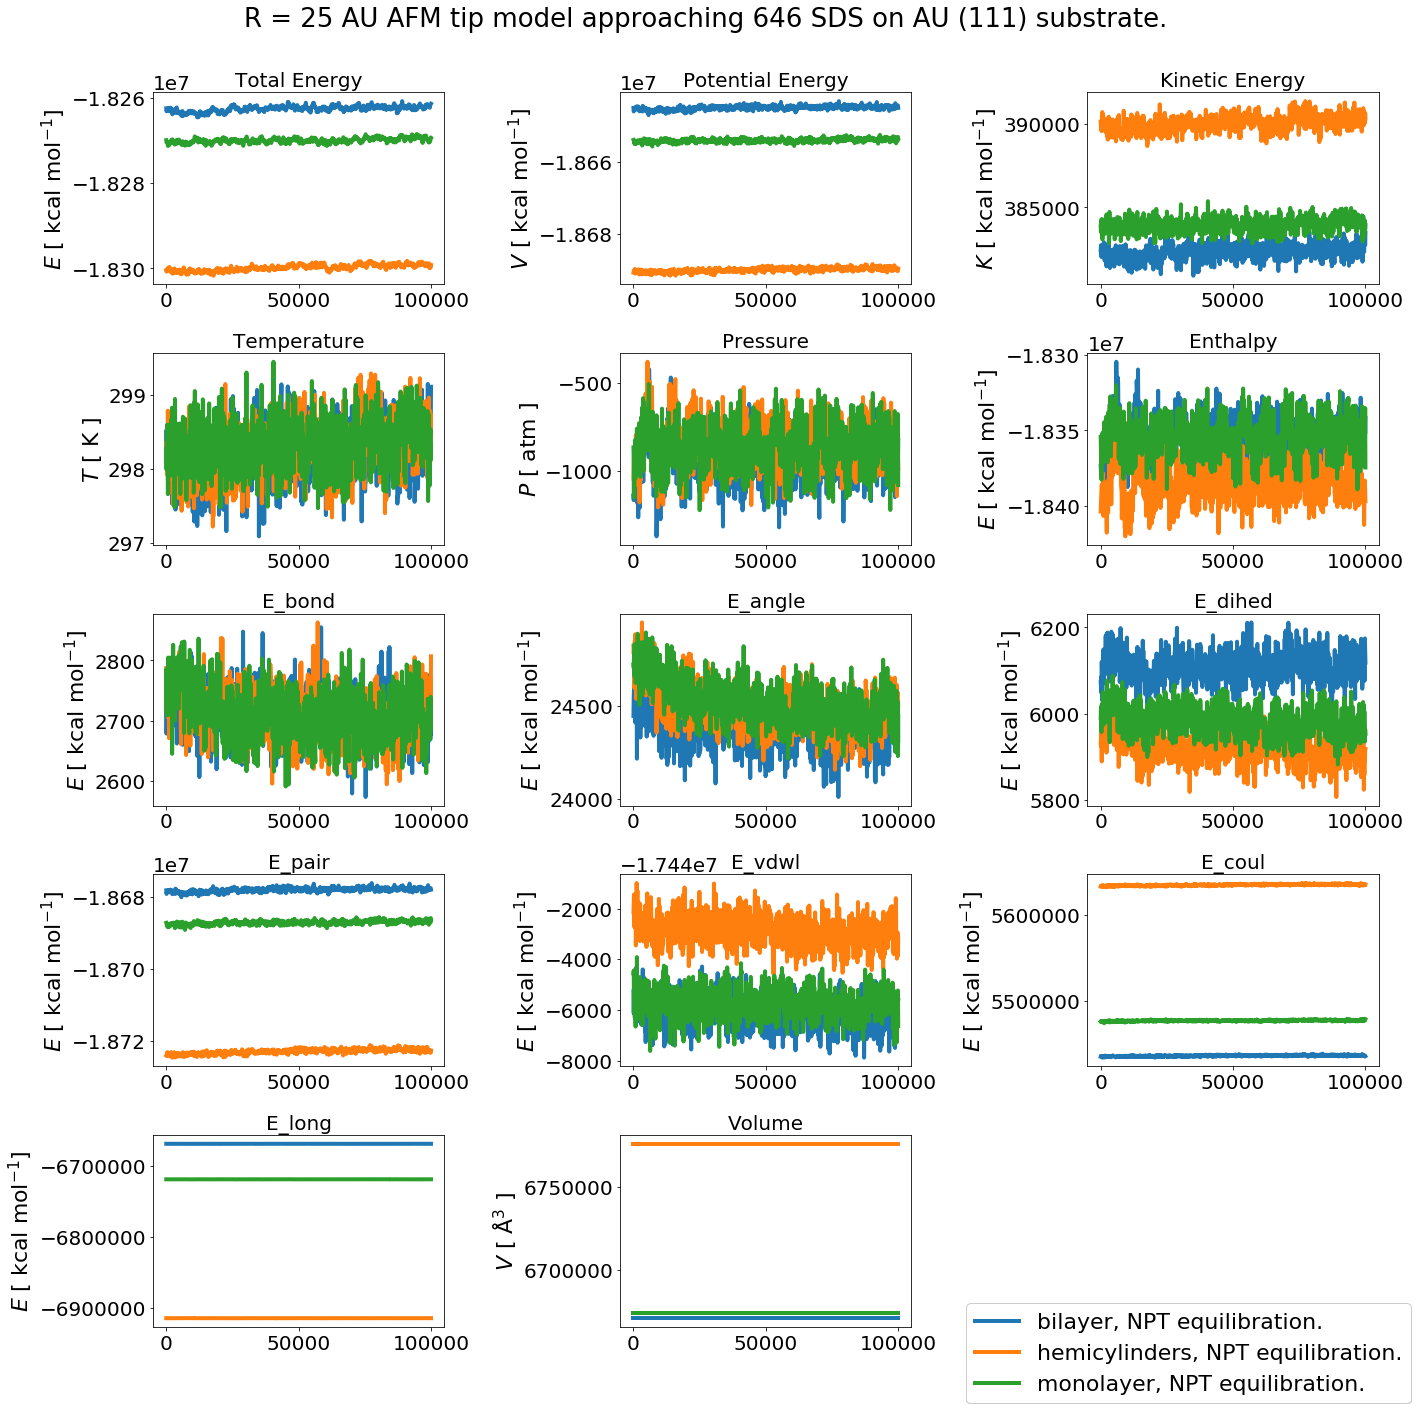

In [181]:
for i, d in enumerate(thermoData):
    if i == 0:
        fig, ax = plotThermo(d["data"], 
                     legend =d["legend"],
                     title  =d["title"])
    else:
        fig, ax = plotThermo(d["data"], axes=ax,
                        legend=d["legend"])

## 1 m per s, DPD thermostat

In [141]:
query = {
    'metadata.surfactant':     'SDS',
    'metadata.sf_nmolecules':  646,
    'metadata.step':           'equilibration_dpd',
    'metadata.sf_preassembly': 'monolayer',
    'metadata.indenter.initial_radius': 25}
    

In [142]:
files = fp.get_file_by_query(query)

In [143]:
for c,d in files:
    print(d["identifier"])

AFM/AU/111/25Ang/100ns/AU/111/51x30x21/SDS/646/monolayer/equilibration_dpd/thermo_ave.out
AFM/AU/111/25Ang/100ns/AU/111/51x30x21/SDS/646/monolayer/equilibration_dpd/default.lammps
AFM/AU/111/25Ang/100ns/AU/111/51x30x21/SDS/646/monolayer/equilibration_dpd/groups.ndx
AFM/AU/111/25Ang/100ns/AU/111/51x30x21/SDS/646/monolayer/equilibration_dpd/log.lammps
AFM/AU/111/25Ang/100ns/AU/111/51x30x21/SDS/646/monolayer/equilibration_dpd/thermo.out


In [144]:
len(files)

5

### Forces

In [637]:
query = {
    'identifier': { '$regex': '.*indenter_forces\.txt$'},
    'metadata.surfactant':     'SDS',
    'metadata.sf_nmolecules':  646,
    'metadata.use_dpd_tstat':  {'$in': [1, True]},
    'metadata.constant_indenter_velocity': -1.0e-5 }
    #'metadata.indenter_dist':  7.5}

In [638]:
files = fp.get_file_by_query(query)

In [639]:
len(files)

2

In [640]:
title_pattern = '''R = {indenter_initial_radius:} {indenter_substrate:} AFM
    tip model approaching {sf_nmolecules:} {surfactant:} on 
    {substrate:} ({sb_crystal_plane:}) substrate.'''

In [641]:
legend_pattern = '''{sf_preassembly:}, v = {constant_indenter_velocity:g} 
    $\mathrm{{m}}\ \mathrm{{s}}^{{-1}}$, {thermostat:} thermostat.'''

In [642]:
plotData = []
for (cont,doc) in files:
    # create a title from document metadata
    title_raw = title_pattern.format(
        indenter_initial_radius = doc["metadata"]["indenter"]["initial_radius"],
        indenter_substrate = doc["metadata"]["indenter"]["substrate"],
        sf_nmolecules = doc["metadata"]["sf_nmolecules"],
        surfactant = doc["metadata"]["surfactant"],
        sf_preassembly = doc["metadata"]["sf_preassembly"],
        substrate = doc["metadata"]["substrate"],
        sb_crystal_plane = doc["metadata"]["sb_crystal_plane"])
    title = ' '.join(line.strip() for line in title_raw.splitlines())
    
    # create a plot legend from document metadata
    legend_raw = legend_pattern.format(
            sf_preassembly = doc["metadata"]["sf_preassembly"],
            constant_indenter_velocity = velocity_conversion_factor*doc["metadata"]["constant_indenter_velocity"],
            thermostat = "Langevin" if doc["metadata"]["use_dpd_tstat"] == 0 else "DPD")

    legend = ' '.join(line.strip() for line in legend_raw.splitlines())
    
    contStream = io.StringIO(cont.decode())
    df = pd.read_csv(contStream,index_col=0, delim_whitespace=True)
    df.index.name = 'time'
    df["distance"] = \
        doc["metadata"]["sb_in_dist"] + df.index * doc["metadata"]["constant_indenter_velocity"]
    plotData.append({'title': title, 'legend': legend, 'data': df})

In [643]:
plotData[0]["title"]

'R = 25 AU AFM tip model approaching 646 SDS on AU (111) substrate.'

In [644]:
plotData[0]["data"].head()

,forces,f_storeAnteShakeForces,f_storeAnteStatForces,f_storeAnteFreezeForces,f_storeUnconstrainedForces,f_storeAnteShakeForcesAve,f_storeAnteStatForcesAve,f_storeUnconstrainedForcesAve,distance
time,,,,,,,,,
0.0,-844.962,-844.962,-844.962,-800.5350,-800.5350,0.0000,0.0000,0.0000,30.0
10000.0,537.964,537.964,537.964,80.1879,80.1879,52.8071,52.8071,-134.2130,29.9
20000.0,-249.156,-249.156,-249.156,-102.4450,-102.4450,-77.6155,-77.6155,11.3534,29.8
30000.0,202.717,202.717,202.717,-88.1760,-88.1760,32.0141,32.0141,50.8402,29.7
40000.0,-273.701,-273.701,-273.701,182.8160,182.8160,-5.1587,-5.1587,-38.3427,29.6


In [645]:
# windows = np.array([1,10,1,10]) # do average on the same scale, i.e. 2ps

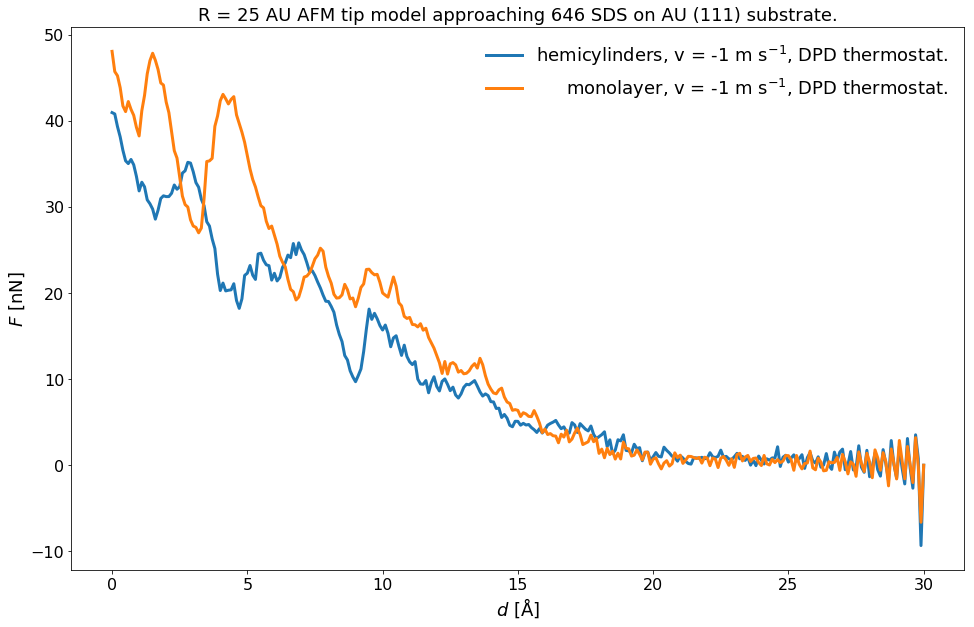

In [646]:
figure = plt.figure()
for d in plotData:
    dat = d["data"]
    tit = d["title"]
    lab = d["legend"]
    
    plt.plot(
        dat["distance"],
        force_conversion_factor*dat["f_storeUnconstrainedForcesAve"],
                #(0.0 < dat.index) & (dat.index < 4.0)].rolling(window=win,center=True).mean(),
        label = lab) 
    
plt.xlabel(distance_label)
plt.ylabel(force_label)
plt.title(tit)
#plt.legend(frameon=False,ncol=2)
#plt.tight_layout(pad=1)
legend = plt.legend(frameon=False,loc='upper right')

renderer = figure.canvas.get_renderer()
# get the width of your widest label, since every label will need 
# to shift by this amount after we align to the right
shift = max([t.get_window_extent(renderer).width for t in legend.get_texts()])
for t in legend.get_texts():
    t.set_ha('right') # ha is alias for horizontalalignment
    t.set_position((shift,0))

### Thermo output

In [654]:
query = {
    'identifier': { '$regex': '.*thermo\.out$'},
    'metadata.surfactant':     'SDS',
    'metadata.sf_nmolecules':  646,
    'metadata.use_dpd_tstat':  {'$in': [1, True]},
    'metadata.constant_indenter_velocity': -1.0e-5 }

In [655]:
files = fp.get_file_by_query(query)

In [656]:
len(files)

2

In [657]:
thermoData = []
for (cont,doc) in files:
    # create a title from document metadata
    title_raw = title_pattern.format(
        indenter_initial_radius = doc["metadata"]["indenter"]["initial_radius"],
        indenter_substrate = doc["metadata"]["indenter"]["substrate"],
        sf_nmolecules = doc["metadata"]["sf_nmolecules"],
        surfactant = doc["metadata"]["surfactant"],
        sf_preassembly = doc["metadata"]["sf_preassembly"],
        substrate = doc["metadata"]["substrate"],
        sb_crystal_plane = doc["metadata"]["sb_crystal_plane"])
    title = ' '.join(line.strip() for line in title_raw.splitlines())
    
    # create a plot legend from document metadata
    legend_raw = legend_pattern.format(
            sf_preassembly = doc["metadata"]["sf_preassembly"],
            constant_indenter_velocity = velocity_conversion_factor*doc["metadata"]["constant_indenter_velocity"],
            thermostat = "Langevin" if doc["metadata"]["use_dpd_tstat"] == 0 else "DPD")

    legend = ' '.join(line.strip() for line in legend_raw.splitlines())
    
    contStream = io.StringIO(cont.decode())
    df = pd.read_csv(contStream,delim_whitespace=True)
    #df.index.name = 'time'
    #df["distance"] = \
    #    doc["metadata"]["sb_in_dist"] + df.index * doc["metadata"]["constant_indenter_velocity"]
    thermoData.append({'title': title, 'legend': legend, 'data': df})

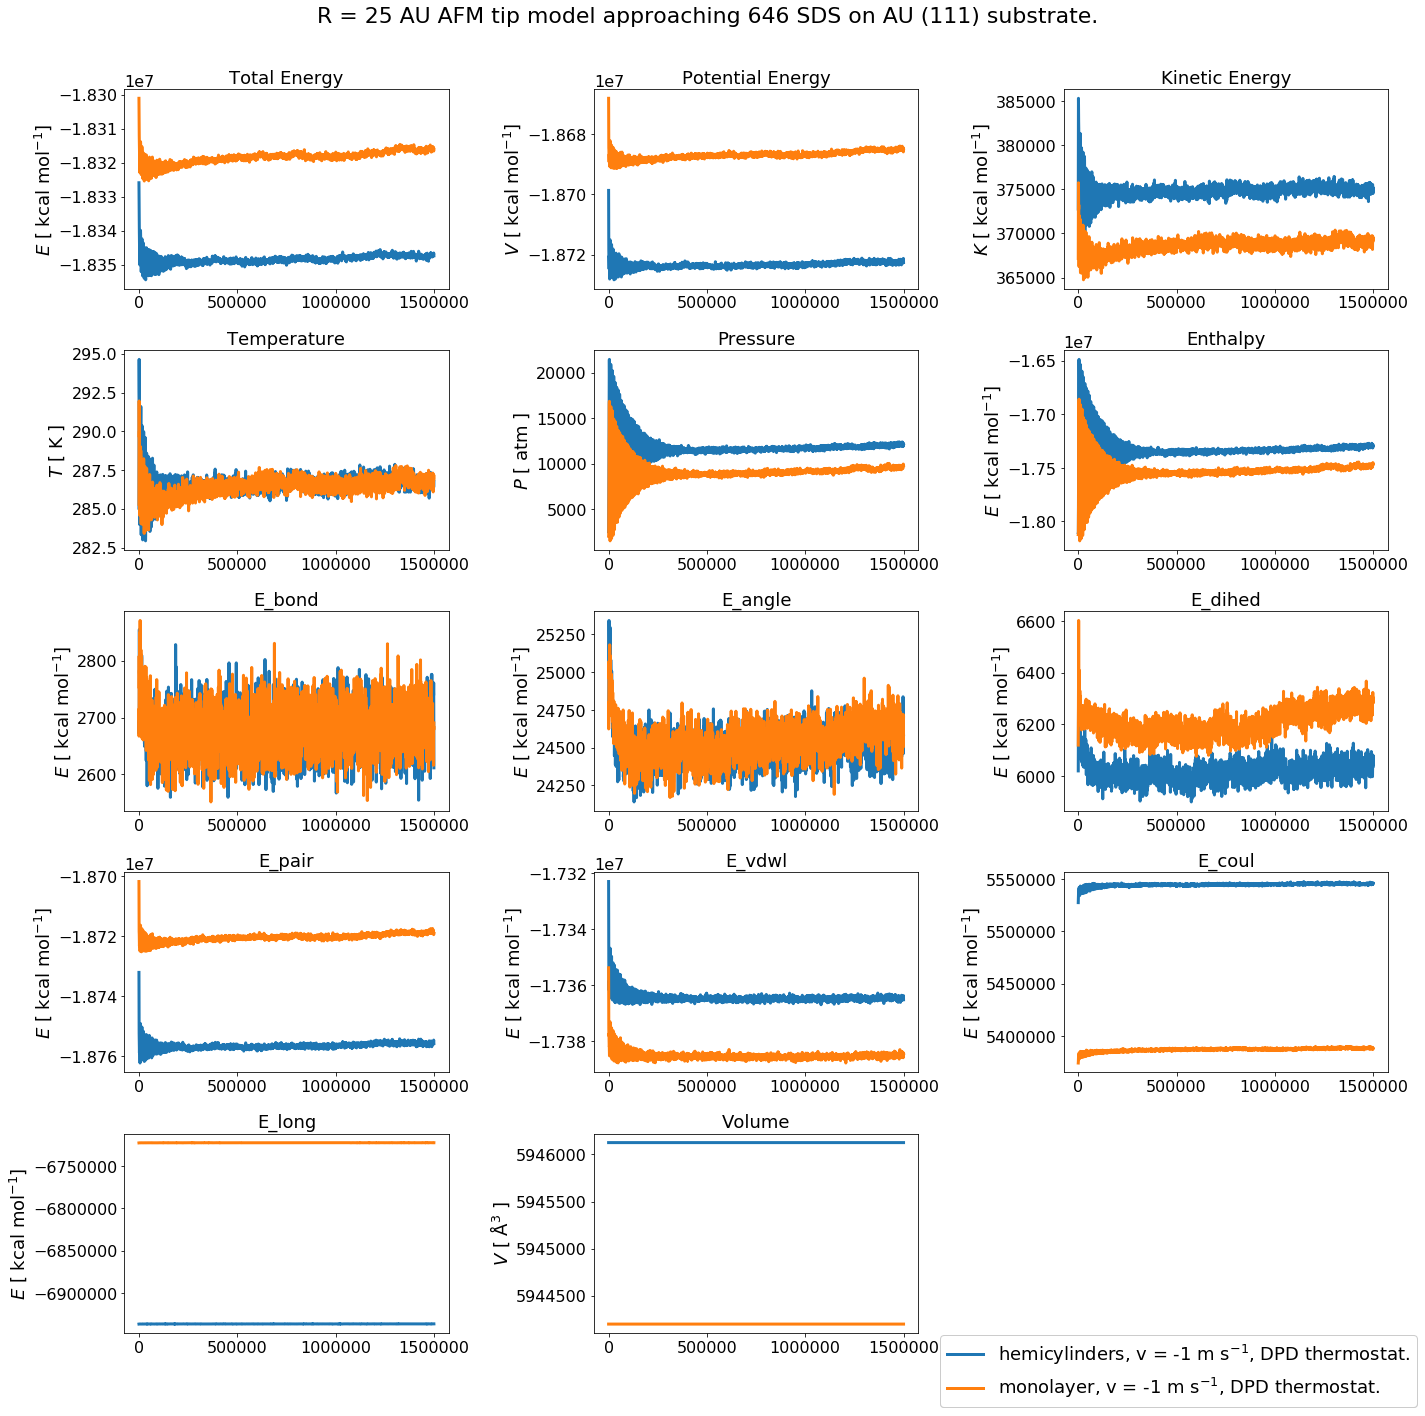

In [658]:
for i, d in enumerate(thermoData):
    if i == 0:
        fig, ax = plotThermo(d["data"], 
                     legend =d["legend"],
                     title  =d["title"])
    else:
        fig, ax = plotThermo(d["data"], axes=ax,
                        legend=d["legend"])

## 10 m / s, DPD and Langevin thermostat

### Forces

In [647]:
query = {
    'identifier': { '$regex': '.*indenter_forces\.txt$'},
    'metadata.surfactant':     'SDS',
    'metadata.sf_nmolecules':  646,
    'metadata.use_dpd_tstat':  {'$exists': True},
    'metadata.constant_indenter_velocity': -1.0e-4 }

In [648]:
files = fp.get_file_by_query(query)

In [649]:
len(files)

4

In [650]:
title_pattern = '''R = {indenter_initial_radius:} {indenter_substrate:} AFM
    tip model approaching {sf_nmolecules:} {surfactant:} on 
    {substrate:} ({sb_crystal_plane:}) substrate.'''

In [651]:
legend_pattern = '''{sf_preassembly:}, v = {constant_indenter_velocity:g} 
    $\mathrm{{m}}\ \mathrm{{s}}^{{-1}}$, {thermostat:} thermostat.'''

In [652]:
plotData = []
for (cont,doc) in files:
    # create a title from document metadata
    title_raw = title_pattern.format(
        indenter_initial_radius = doc["metadata"]["indenter"]["initial_radius"],
        indenter_substrate = doc["metadata"]["indenter"]["substrate"],
        sf_nmolecules = doc["metadata"]["sf_nmolecules"],
        surfactant = doc["metadata"]["surfactant"],
        sf_preassembly = doc["metadata"]["sf_preassembly"],
        substrate = doc["metadata"]["substrate"],
        sb_crystal_plane = doc["metadata"]["sb_crystal_plane"])
    title = ' '.join(line.strip() for line in title_raw.splitlines())
    
    # create a plot legend from document metadata
    legend_raw = legend_pattern.format(
            sf_preassembly = doc["metadata"]["sf_preassembly"],
            constant_indenter_velocity = velocity_conversion_factor*np.abs(doc["metadata"]["constant_indenter_velocity"]),
            thermostat = "Langevin" if doc["metadata"]["use_dpd_tstat"] == 0 else "DPD")

    legend = ' '.join(line.strip() for line in legend_raw.splitlines())
    
    contStream = io.StringIO(cont.decode())
    df = pd.read_csv(contStream,index_col=0, delim_whitespace=True)
    df.index.name = 'time'
    df["distance"] = \
        doc["metadata"]["sb_in_dist"] + df.index * doc["metadata"]["constant_indenter_velocity"]
    plotData.append({'title': title, 'legend': legend, 'data': df})

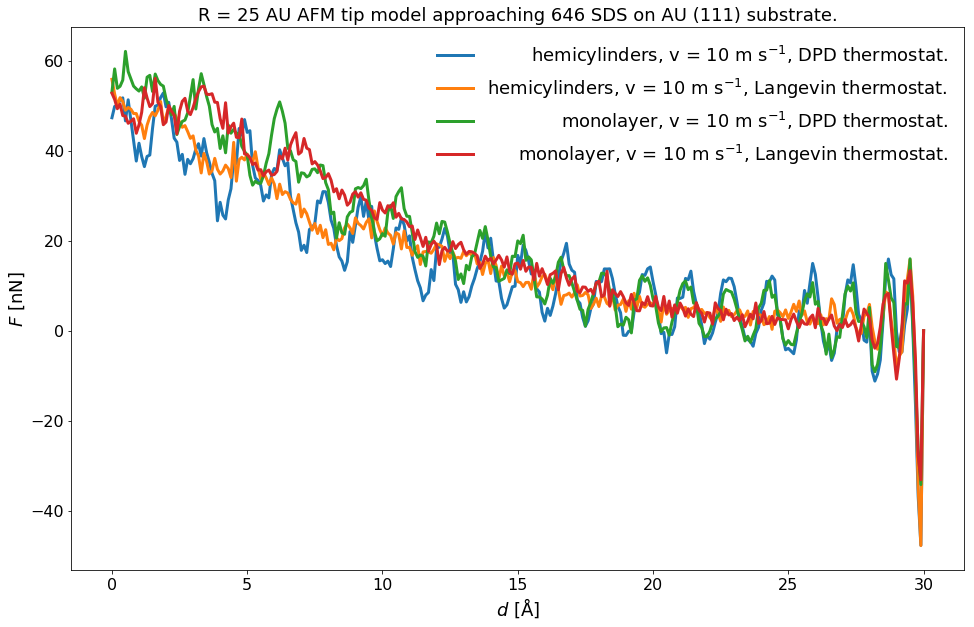

In [653]:
figure = plt.figure()
for d in plotData:
    dat = d["data"]
    tit = d["title"]
    lab = d["legend"]
    
    plt.plot(
        dat["distance"],
        force_conversion_factor*dat["f_storeUnconstrainedForcesAve"],
                #(0.0 < dat.index) & (dat.index < 4.0)].rolling(window=win,center=True).mean(),
        label = lab) 
    
plt.xlabel(distance_label)
plt.ylabel(force_label)
plt.title(tit)
#plt.legend(frameon=False,ncol=2)
#plt.tight_layout(pad=1)
legend = plt.legend(frameon=False,loc='upper right')

renderer = figure.canvas.get_renderer()
# get the width of your widest label, since every label will need 
# to shift by this amount after we align to the right
shift = max([t.get_window_extent(renderer).width for t in legend.get_texts()])
for t in legend.get_texts():
    t.set_ha('right') # ha is alias for horizontalalignment
    t.set_position((shift,0))

### Thermo output

In [659]:
query = {
    'identifier': { '$regex': '.*thermo\.out$'},
    'metadata.surfactant':     'SDS',
    'metadata.sf_nmolecules':  646,
    'metadata.use_dpd_tstat':  {'$exists': True},
    'metadata.constant_indenter_velocity': -1.0e-4 }

In [660]:
files = fp.get_file_by_query(query)

In [661]:
len(files)

4

In [667]:
files[1][1]

{'_id': ObjectId('5d00e7abb1990ab5612327b2'),
 'identifier': 'AFM/AU/111/25Ang/100ns/AU/111/51x30x21/SDS/646/hemicylinders/-0.0001Ang_per_fs/production/langevin_tstat/thermo.out',
 'original_file_name': 'thermo.out',
 'original_file_path': '/work/ws/nemo/fr_jh1130-fw_ws_20190311-0/launchpad/launcher_2019-06-12-11-53-01-701195/thermo.out',
 'metadata': {'ci_preassembly': 'at polar heads',
  'constant_indenter_velocity': -0.0001,
  'constant_indenter_velocity_unit': 'Ang_per_fs',
  'coulomb_cutoff': 8.0,
  'counterion': 'NA',
  'ewald_accuracy': 0.0001,
  'force_field': 'charmm36',
  'indenter': {'crystal_plane': 111,
   'equilibration_time_span': 50,
   'equilibration_time_span_unit': 'ps',
   'initial_radius': 25,
   'initial_radius_unit': 'Ang',
   'initial_shape': 'sphere',
   'lammps_units': 'real',
   'melting_final_temperature': 1800,
   'melting_time_span': 10,
   'melting_time_span_unit': 'ns',
   'minimization_ftol': 1e-05,
   'minimization_ftol_unit': 'kcal',
   'natoms': 3873

In [662]:
thermoData = []
for (cont,doc) in files:
    # create a title from document metadata
    title_raw = title_pattern.format(
        indenter_initial_radius = doc["metadata"]["indenter"]["initial_radius"],
        indenter_substrate = doc["metadata"]["indenter"]["substrate"],
        sf_nmolecules = doc["metadata"]["sf_nmolecules"],
        surfactant = doc["metadata"]["surfactant"],
        sf_preassembly = doc["metadata"]["sf_preassembly"],
        substrate = doc["metadata"]["substrate"],
        sb_crystal_plane = doc["metadata"]["sb_crystal_plane"])
    title = ' '.join(line.strip() for line in title_raw.splitlines())
    
    # create a plot legend from document metadata
    legend_raw = legend_pattern.format(
            sf_preassembly = doc["metadata"]["sf_preassembly"],
            constant_indenter_velocity = velocity_conversion_factor*doc["metadata"]["constant_indenter_velocity"],
            thermostat = "Langevin" if doc["metadata"]["use_dpd_tstat"] == 0 else "DPD")

    legend = ' '.join(line.strip() for line in legend_raw.splitlines())
    
    contStream = io.StringIO(cont.decode())
    df = pd.read_csv(contStream,delim_whitespace=True)
    thermoData.append({'title': title, 'legend': legend, 'data': df})

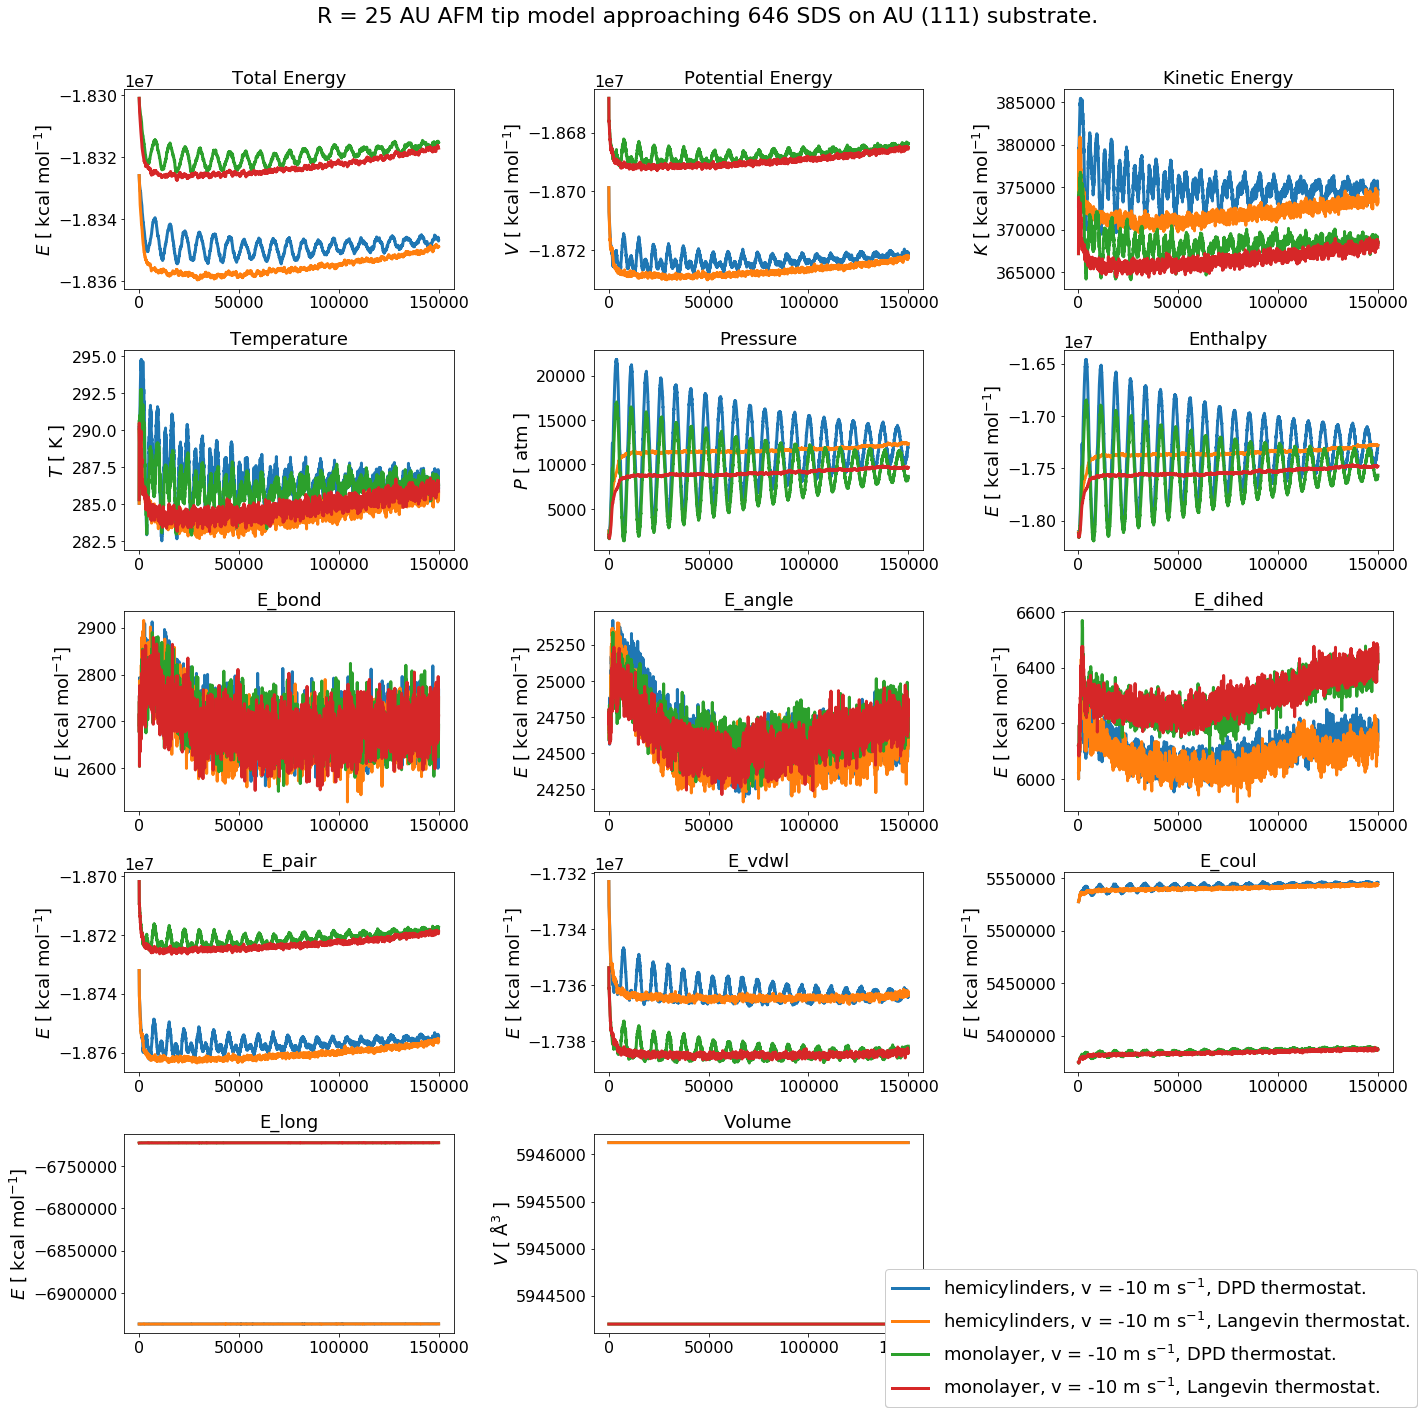

In [663]:
for i, d in enumerate(thermoData):
    if i == 0:
        fig, ax = plotThermo(d["data"], 
                     legend =d["legend"],
                     title  =d["title"])
    else:
        fig, ax = plotThermo(d["data"], axes=ax,
                        legend=d["legend"])